# 신용카드 사기 거래 탐지 AI - 202192006 최장호

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score


import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf1.Session(config=config)

2024-03-28 03:53:40.809794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 03:53:41.096558: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 03:53:42.845265: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-28 03:53:42.845447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

# 중요한 feature 선택

In [94]:
# 데이터 로드
path = '/home/a202192006/신용카드 사기 거래 탐지 AI 만들기/data/'

train_df = pd.read_csv(path + 'train.csv')
train_df = train_df.drop(columns=['ID'])

test_data = pd.read_csv(path + 'test.csv')

val_df = pd.read_csv(path + 'val.csv')
val_df = val_df.drop(columns=['ID'])

In [28]:
correlation_matrix = val_df.corr()

class_correlation = correlation_matrix['Class']

sorted_correlation = class_correlation.abs().sort_values(ascending=False)

print(sorted_correlation)

Class    1.000000
V17      0.290434
V14      0.270852
V12      0.239264
V10      0.226813
V7       0.214810
V3       0.212345
V16      0.169542
V11      0.142082
V4       0.126146
V5       0.112254
V1       0.109284
V9       0.098666
V2       0.096823
V18      0.096104
V6       0.045676
V27      0.043127
V8       0.038359
V19      0.024223
V28      0.018156
V22      0.016996
V20      0.015873
V30      0.010476
V24      0.010131
V15      0.009532
V26      0.005371
V23      0.005015
V25      0.003573
V13      0.001800
V29      0.001762
V21      0.001090
Name: Class, dtype: float64


## Feature 선정
- V17  :     0.290434
- V14  :     0.270852
- V12  :     0.239264
- V10  :     0.226813
- V7   :     0.214810
- V3   :     0.212345
- V16  :     0.169542
- V11  :     0.142082
- V4   :     0.126146
- V5   :     0.112254

In [33]:
# 클래스 별로 나눔
class_1_df = val_df[val_df['Class'] == 1]


class_0_df = val_df[val_df['Class'] == 0]

#### class_1_df와 class_0_df 두 독립적인 집단에서 선택한 변수들에 대해 독립표본 T검정을 수행
#### equal_var=False는 두 집단의 분산이 다르다고 가정하는 Welch의 t-test를 의미
#### 각 변수별 T-통계량과 P-값을 통해, 두 집단 간 평균 차이의 통계적 유의성을 검증

 
- T-statistic 값이 크고 음수일 경우, 사기 거래 그룹의 평균이 정상 거래 그룹보다 낮음을 의미합니다. 
- 반대로 양수일 경우 사기 거래 그룹의 평균이 더 높음을 의미합니다.
- P-value 가 0.05 이하일 경우, 두 그룹 간의 평균 차이가 통계적으로 유의미하다고 볼 수 있습니다.

In [42]:
features = []  
for i in range(1, 31):
    features.append(f'V{i}')  

In [44]:
from scipy import stats

for feature in features:
    t_stat, p_value = stats.ttest_ind(class_1_df[feature], class_0_df[feature], equal_var=False)
    print(f'Feature: {feature}')
    print(f'T-statistic: {t_stat:.2f}, P-value: {p_value:.5f}\n')


Feature: V1
T-statistic: -4.45, P-value: 0.00012

Feature: V2
T-statistic: 5.93, P-value: 0.00000

Feature: V3
T-statistic: -6.00, P-value: 0.00000

Feature: V4
T-statistic: 8.65, P-value: 0.00000

Feature: V5
T-statistic: -3.96, P-value: 0.00044

Feature: V6
T-statistic: -6.77, P-value: 0.00000

Feature: V7
T-statistic: -4.71, P-value: 0.00006

Feature: V8
T-statistic: 1.46, P-value: 0.15444

Feature: V9
T-statistic: -6.91, P-value: 0.00000

Feature: V10
T-statistic: -6.59, P-value: 0.00000

Feature: V11
T-statistic: 8.28, P-value: 0.00000

Feature: V12
T-statistic: -7.58, P-value: 0.00000

Feature: V13
T-statistic: 0.27, P-value: 0.79238

Feature: V14
T-statistic: -9.81, P-value: 0.00000

Feature: V15
T-statistic: -1.24, P-value: 0.22544

Feature: V16
T-statistic: -5.43, P-value: 0.00001

Feature: V17
T-statistic: -5.29, P-value: 0.00001

Feature: V18
T-statistic: -4.08, P-value: 0.00032

Feature: V19
T-statistic: 1.85, P-value: 0.07443

Feature: V20
T-statistic: 1.63, P-value: 0.112

#### P-value가 매우 낮고, T-statistic의 절대값이 큰 Feature들이사기 거래와 정상 거래를 구분하는 데 더 유용할 것이라고 생각하기에 

- V14: T-statistic: -9.81, P-value: 0.00000
- V4: T-statistic: 8.65, P-value: 0.00000
- V12: T-statistic: -7.58, P-value: 0.00000
- V11: T-statistic: 8.28, P-value: 0.00000
- V10: T-statistic: -6.59, P-value: 0.00000
- V9: T-statistic: -6.91, P-value: 0.00000
- V6: T-statistic: -6.77, P-value: 0.00000
- V3: T-statistic: -6.00, P-value: 0.00000
- V16: T-statistic: -5.43, P-value: 0.00001
- V17: T-statistic: -5.29, P-value: 0.00001

#### 선정

## 상관계수 그리고 T-검정에서 모두 중요도가 높게 평가된 Feature를 고려하기로 함(일관성 있다고 생각함)

- V17: T-검정에서는 P-value가 매우 낮으며, 상관계수 분석에서도 상대적으로 높은 상관계수를 보임
- V14: T-검정에서 가장 큰 절대값의 T-statistic을 보이며, 상관계수 분석에서도 높은 상관계수를 보임
- V12: T-검정과 상관계수 분석 모두에서 중요한 Feature로 나타남
- V11: T-검정에서 높은 T-statistic을 보이며, 상관계수 분석에서도 중요한 Feature로 보임
- V10: 두 분석 방법 모두에서 중요한 Feature로 평가됨
- V4: T-검정에서 높은 T-statistic을 가지며, 상관계수 분석에서도 중요도가 확인됨
- V3: 두 분석 방법에서 모두 중요한 Feature로 평가됨
- V16: 두 방법 모두에서 중요도가 높게 평가됨


### V3 , V4, V10 , V11 , V12, V14, V16, V17

In [46]:
train_df[]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113837,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,8.655320,...,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,-0.169496,1.034857
113838,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,0.120908,...,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0.530986,1.034881
113839,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,-0.230699,1.034904
113840,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,-0.269825,1.034939


In [163]:
import pandas as pd

train_df = train_df[['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']]


In [197]:
test_data = test_data[['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']]

In [165]:
val_df = val_df[['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17','Class']]

In [98]:
val_df

,V3,V4,V10,V11,V12,V14,V16,V17,Class
0,1.044367,-0.222187,-0.366846,1.017614,0.836390,-0.443523,0.739453,-0.540980,0
1,-0.171479,2.109204,0.724396,1.690330,0.406774,0.983739,-0.602232,0.402484,0
2,0.194008,2.598192,0.757952,-0.448937,-0.660863,0.788864,0.295404,-0.287878,0
3,0.387585,0.544474,-0.225495,1.944545,1.385160,0.314166,-1.333716,1.002869,0
4,1.483691,-2.418473,6.051521,2.572500,0.066851,-2.837136,-0.303774,-1.942303,0
...,...,...,...,...,...,...,...,...,...
28457,-0.313252,0.926044,-0.077753,0.534689,0.748099,1.018502,-0.914161,0.143397,0
28458,-0.907599,-0.418847,-1.245088,0.874312,0.162691,-0.317789,0.482847,0.681412,0
28459,-0.168583,0.981577,0.076605,-1.291228,-0.690868,0.753473,-1.129904,0.319074,0
28460,-1.196825,0.234580,0.267772,0.523316,0.559047,0.626211,0.225361,-0.605252,0


In [77]:
print(train_df)

              V3        V4       V10       V11       V12       V14       V16  \
0       1.773209  0.379780  0.207643  0.624501  0.066084 -0.165946 -2.890083   
1       1.792993 -0.863291 -0.054952 -0.226487  0.178228 -0.287924 -1.059647   
2       1.141109 -0.168252 -0.371407  1.341262  0.359894 -0.137134  0.401726   
3       1.074380 -0.492199  1.249376 -0.619468  0.291474 -1.323865 -0.076127   
4      -0.113192 -0.271526 -0.410430 -0.705117 -0.110452  0.074355 -0.210077   
...          ...       ...       ...       ...       ...       ...       ...   
113837 -8.476671 -2.510473  8.655320 -1.052365  2.834865  1.288401  1.067864   
113838 -0.999943  1.506772  0.120908 -1.134176  0.677729  0.002019 -0.549982   
113839  0.399806 -0.463406 -0.284708 -0.612982 -0.066655  0.237948 -0.245496   
113840 -0.546012 -0.745097 -0.657422  0.644837  0.190916 -0.731707  0.599628   
113841 -9.834783 -2.066656  4.356170 -1.593105  2.711941  4.626942  1.107641   

             V17  
0       1.109969  
1

In [99]:
from sklearn.ensemble import IsolationForest

# Isolation Forest 모델 생성
model = IsolationForest(n_estimators=125, contamination=0.0010551491277433877, random_state=42)

# 모델 학습
model.fit(train_df)

# 이상치 예측 (-1은 이상치, 1은 정상)
scores_prediction = model.predict(train_df)

# 결과를 0과 1로 변환 (1은 정상, 0은 이상치)
scores_prediction[scores_prediction == 1] = 0  # 정상
scores_prediction[scores_prediction == -1] = 1  # 이상치(사기 거래)

# 결과 확인
print(np.unique(scores_prediction, return_counts=True))

# 결과를 DataFrame에 추가
train_df['Class'] = scores_prediction

# 결과 확인
print(train_df)

(array([0, 1]), array([112703,   1139]))
              V3        V4       V10       V11       V12       V14       V16  \
0       1.773209  0.379780  0.207643  0.624501  0.066084 -0.165946 -2.890083   
1       1.792993 -0.863291 -0.054952 -0.226487  0.178228 -0.287924 -1.059647   
2       1.141109 -0.168252 -0.371407  1.341262  0.359894 -0.137134  0.401726   
3       1.074380 -0.492199  1.249376 -0.619468  0.291474 -1.323865 -0.076127   
4      -0.113192 -0.271526 -0.410430 -0.705117 -0.110452  0.074355 -0.210077   
...          ...       ...       ...       ...       ...       ...       ...   
113837 -8.476671 -2.510473  8.655320 -1.052365  2.834865  1.288401  1.067864   
113838 -0.999943  1.506772  0.120908 -1.134176  0.677729  0.002019 -0.549982   
113839  0.399806 -0.463406 -0.284708 -0.612982 -0.066655  0.237948 -0.245496   
113840 -0.546012 -0.745097 -0.657422  0.644837  0.190916 -0.731707  0.599628   
113841 -9.834783 -2.066656  4.356170 -1.593105  2.711941  4.626942  1.107641   

In [100]:
num_class_1 = train_df[train_df['Class'] == 1].shape[0]

print(f"'Class' 컬럼에서 값이 1인 데이터의 개수: {num_class_1}")


'Class' 컬럼에서 값이 1인 데이터의 개수: 1139


In [83]:
train_df

,V3,V4,V10,V11,V12,V14,V16,V17,Class
0,1.773209,0.379780,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,0
1,1.792993,-0.863291,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,0
2,1.141109,-0.168252,-0.371407,1.341262,0.359894,-0.137134,0.401726,-0.058133,0
3,1.074380,-0.492199,1.249376,-0.619468,0.291474,-1.323865,-0.076127,-1.222127,0
4,-0.113192,-0.271526,-0.410430,-0.705117,-0.110452,0.074355,-0.210077,-0.499768,0
...,...,...,...,...,...,...,...,...,...
113837,-8.476671,-2.510473,8.655320,-1.052365,2.834865,1.288401,1.067864,0.586179,1
113838,-0.999943,1.506772,0.120908,-1.134176,0.677729,0.002019,-0.549982,-0.199950,0
113839,0.399806,-0.463406,-0.284708,-0.612982,-0.066655,0.237948,-0.245496,-0.174846,0
113840,-0.546012,-0.745097,-0.657422,0.644837,0.190916,-0.731707,0.599628,0.070441,0


# Isoloation Forest에서 찾은 이상치를 Y로 두고 지도학습 실시

In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras


In [102]:
X_train = train_df.drop('Class', axis=1)
y_train = train_df['Class']
X_val = val_df.drop('Class', axis=1)
y_val = val_df['Class']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  

In [103]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

2024-03-27 23:02:40.608702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12101 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


In [104]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train_scaled, y_train,
                    epochs=20,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[early_stopping_callback])

Epoch 1/20


2024-03-27 23:02:54.853657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2847/2847 [==============================] - 21s 6ms/step - loss: 0.0576 - accuracy: 0.9915 - val_loss: 0.0284 - val_accuracy: 0.9921
Epoch 2/20
2847/2847 [==============================] - 16s 6ms/step - loss: 0.0152 - accuracy: 0.9951 - val_loss: 0.0230 - val_accuracy: 0.9942
Epoch 3/20
2847/2847 [==============================] - 16s 6ms/step - loss: 0.0123 - accuracy: 0.9953 - val_loss: 0.0264 - val_accuracy: 0.9928
Epoch 4/20
2847/2847 [==============================] - 16s 6ms/step - loss: 0.0109 - accuracy: 0.9958 - val_loss: 0.0218 - val_accuracy: 0.9941
Epoch 5/20
2847/2847 [==============================] - 16s 6ms/step - loss: 0.0103 - accuracy: 0.9957 - val_loss: 0.0284 - val_accuracy: 0.9916
Epoch 6/20
2847/2847 [==============================] - 16s 6ms/step - loss: 0.0099 - accuracy: 0.9959 - val_loss: 0.0322 - val_accuracy: 0.9911
Epoch 7/20
2847/2847 [==============================] - 16s 6ms/step - loss: 0.0094 - accuracy: 0.9962 - val_loss: 0.0325 - val_accuracy: 0.9

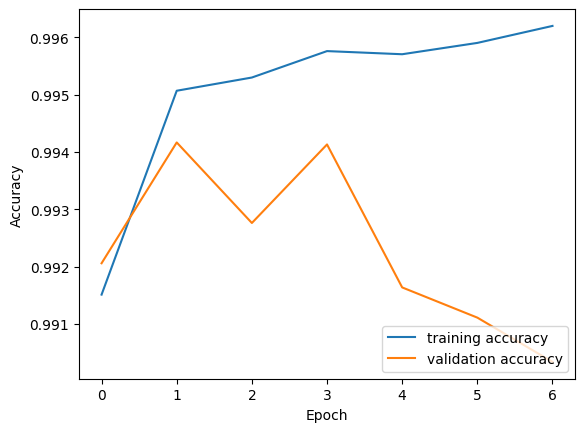

In [105]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [106]:
test_data

,V3,V4,V10,V11,V12,V14,V16,V17
0,2.536347,1.378155,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971
1,0.166480,0.448154,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805
2,1.548718,0.403034,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033
3,0.045371,1.202613,-0.099254,-1.416907,-0.153826,0.167372,-0.443587,0.002821
4,-0.874300,-0.094019,0.309755,-0.259116,-0.326143,0.362832,-0.129487,-0.809979
...,...,...,...,...,...,...,...,...
142498,-0.635891,0.960928,-0.111640,-1.109232,-0.453235,1.122674,-1.431897,0.939328
142499,1.189786,0.331096,-0.594242,-1.264072,0.453596,-0.858719,-0.644646,0.447184
142500,2.035030,-0.738589,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693
142501,-3.249640,-0.557828,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502


In [108]:
X_test = test_data

# 테스트 데이터 스케일링
X_test_scaled = scaler.transform(X_test)

# 테스트 데이터에 대한 예측 수행
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.round(y_pred).astype(int)  # 확률을 클래스 값으로 변환

# 예측 결과 확인
print(y_pred_classes)

4454/4454 [==============================] - 10s 2ms/step
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [110]:
submit = pd.read_csv(path + 'sample_submission.csv')
submit['Class'] = y_pred_classes
submit.to_csv('./피쳐선정 후 아이솔레이트포레스트 쓰고 지도학습으로 학습함.csv', index=False)

# <center>  64% 결과가 처참함</center>

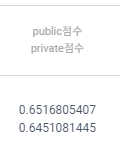

# AutoEncoder 진행

In [251]:
import pandas as pd

train_df = train_df[['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']]
test_data = test_data[['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']]
val_df = val_df[['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17','Class']]

In [252]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

scaler = StandardScaler()
scaled_train_df = scaler.fit_transform(train_df)
scaled_val_df = scaler.transform(val_df.iloc[:, :-1])
scaled_test_data = scaler.fit_transform(test_data)

In [253]:
print(scaled_train_df.shape)
print(scaled_val_df.shape)
print(scaled_test_data.shape)

(113842, 8)
(28462, 8)
(142503, 8)


In [255]:
# Autoencoder 모델 정의
input_dim = scaled_train_df.shape[1]  
input_layer = Input(shape=(input_dim, ))

# 인코더 정의
encoder = Dense(7, activation="tanh")(input_layer)
encoder = Dense(14, activation="relu")(encoder)

# 디코더 정의
decoder = Dense(7, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

# 모델 컴파일
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습을 위한 콜백 설정
checkpointer = ModelCheckpoint(filepath="diff_autoencoder.h5",
                               verbose=0,
                               save_best_only=True)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [ ]:
# 학습 데이터와 검증 데이터 모두 정상 거래 데이터만 사용
history = autoencoder.fit(scaled_train_df, scaled_train_df,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(scaled_val_df, val_df['Class']),
                          verbose=1,
                          callbacks=[checkpointer, early_stopping])



In [247]:
# 예측 및 이상치 탐지
predictions = autoencoder.predict(scaled_test_data)
mse = np.mean(np.power(scaled_test_data - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# 정상과 사기 거래 간의 재구성 오류 임계값 설정
threshold = np.mean(error_df['reconstruction_error']) + 1.5 * np.std(error_df['reconstruction_error'])

# 임계값을 기준으로 사기 거래 예측
error_df['prediction'] = (error_df['reconstruction_error'] > threshold).astype(int)

# 결과 출력
print("예측된 사기 거래 수:", error_df['prediction'].sum())


4454/4454 [==============================] - 14s 3ms/step
예측된 사기 거래 수: 426


In [249]:
error_df['prediction']

0         0
1         0
2         0
3         0
4         0
         ..
142498    0
142499    0
142500    0
142501    0
142502    0
Name: prediction, Length: 142503, dtype: int64

In [250]:
submit = pd.read_csv(path + 'sample_submission.csv')
submit['Class'] = error_df['prediction']
submit.to_csv('./피쳐선정 후 오토인코더.csv', index=False)

# <center>  85% 결과가 나쁘지 않음</center>

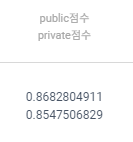

# 모델 구조 변경

In [256]:
from keras.layers import Input, Dense, BatchNormalization, LeakyReLU
from keras.models import Model

input_dim = scaled_train_df.shape[1]
input_layer = Input(shape=(input_dim, ))

# Encoder
encoder = Dense(16)(input_layer)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dense(32)(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)

# Decoder
decoder = Dense(16)(encoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
decoder = Dense(input_dim)(decoder)  

# Autoencoder 모델 구성
autoencoder = Model(inputs=input_layer, outputs=decoder)

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 출력
autoencoder.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 8)]               0         
                                                                 
 dense_64 (Dense)            (None, 16)                144       
                                                                 
 batch_normalization_12 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_65 (Dense)            (None, 32)                544       
                                                                 
 batch_normalization_13 (Bat  (None, 32)               128       
 chNormalization)                                         

In [257]:
# 학습 데이터와 검증 데이터 모두 정상 거래 데이터만 사용
history = autoencoder.fit(scaled_train_df, scaled_train_df,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(scaled_val_df, val_df['Class']),
                          verbose=1,
                          callbacks=[checkpointer, early_stopping])



Epoch 1/100
3558/3558 [==============================] - 48s 11ms/step - loss: 0.1422 - val_loss: 1.0451
Epoch 2/100
3558/3558 [==============================] - 38s 11ms/step - loss: 0.0796 - val_loss: 1.0097
Epoch 3/100
3558/3558 [==============================] - 38s 11ms/step - loss: 0.0688 - val_loss: 0.9841
Epoch 4/100
3558/3558 [==============================] - 38s 11ms/step - loss: 0.0623 - val_loss: 0.9972
Epoch 5/100
3558/3558 [==============================] - 38s 11ms/step - loss: 0.0575 - val_loss: 1.0150
Epoch 6/100
3558/3558 [==============================] - 39s 11ms/step - loss: 0.0553 - val_loss: 0.9693
Epoch 7/100
3558/3558 [==============================] - 38s 11ms/step - loss: 0.0520 - val_loss: 0.9568
Epoch 8/100
3558/3558 [==============================] - 38s 11ms/step - loss: 0.0507 - val_loss: 0.9675
Epoch 9/100
3558/3558 [==============================] - 39s 11ms/step - loss: 0.0483 - val_loss: 0.9538
Epoch 10/100
3558/3558 [==============================]

In [258]:
# 예측 및 이상치 탐지
predictions = autoencoder.predict(scaled_test_data)
mse = np.mean(np.power(scaled_test_data - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# 정상과 사기 거래 간의 재구성 오류 임계값 설정
threshold = np.mean(error_df['reconstruction_error']) + 1.5 * np.std(error_df['reconstruction_error'])

# 임계값을 기준으로 사기 거래 예측
error_df['prediction'] = (error_df['reconstruction_error'] > threshold).astype(int)

# 결과 출력
print("예측된 사기 거래 수:", error_df['prediction'].sum())


4454/4454 [==============================] - 17s 4ms/step
예측된 사기 거래 수: 330


In [259]:
submit = pd.read_csv(path + 'sample_submission.csv')
submit['Class'] = error_df['prediction']
submit.to_csv('./피쳐선정 후 오토인코더 좀 더 깊게.csv', index=False)

##  Val_loss가 줄지가 않음 84%

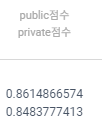

# Dropout 추가 해봄

In [265]:
from keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model

input_dim = scaled_train_df.shape[1]
input_layer = Input(shape=(input_dim, ))

# Encoder
encoder = Dense(16)(input_layer)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dropout(0.5)(encoder)  # Dropout 추가
encoder = Dense(32)(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dense(64)(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dropout(0.5)(encoder)  # Dropout 추가

# Decoder
decoder = Dense(64)(encoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
decoder = Dropout(0.5)(decoder)  # Dropout 추가
decoder = Dense(32)(encoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
decoder = Dropout(0.5)(decoder)  # Dropout 추가
decoder = Dense(16)(encoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
decoder = Dropout(0.5)(decoder)  # Dropout 추가
decoder = Dense(input_dim)(decoder)

# Autoencoder 모델 구성
autoencoder = Model(inputs=input_layer, outputs=decoder)

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 출력
autoencoder.summary()


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 8)]               0         
                                                                 
 dense_84 (Dense)            (None, 16)                144       
                                                                 
 batch_normalization_27 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 16)                0         
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_85 (Dense)            (None, 32)                544       
                                                          

In [266]:
# 학습 데이터와 검증 데이터 모두 정상 거래 데이터만 사용
history = autoencoder.fit(scaled_train_df, scaled_train_df,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(scaled_val_df, val_df['Class']),
                          verbose=1,
                          callbacks=[checkpointer, early_stopping])



Epoch 1/100
3558/3558 [==============================] - 51s 12ms/step - loss: 0.7538 - val_loss: 0.1703
Epoch 2/100
3558/3558 [==============================] - 41s 12ms/step - loss: 0.6444 - val_loss: 0.1932
Epoch 3/100
3558/3558 [==============================] - 41s 12ms/step - loss: 0.6338 - val_loss: 0.1805
Epoch 4/100
3558/3558 [==============================] - 41s 12ms/step - loss: 0.6316 - val_loss: 0.1862
Epoch 5/100
3558/3558 [==============================] - 42s 12ms/step - loss: 0.6295 - val_loss: 0.1909
Epoch 6/100
3558/3558 [==============================] - 41s 12ms/step - loss: 0.6263 - val_loss: 0.1917
Epoch 7/100
3558/3558 [==============================] - 41s 11ms/step - loss: 0.6229 - val_loss: 0.1831
Epoch 8/100
3558/3558 [==============================] - 42s 12ms/step - loss: 0.6241 - val_loss: 0.1931
Epoch 9/100
3558/3558 [==============================] - 41s 12ms/step - loss: 0.6233 - val_loss: 0.1915
Epoch 10/100
3558/3558 [==============================]

In [267]:
# 예측 및 이상치 탐지
predictions = autoencoder.predict(scaled_test_data)
mse = np.mean(np.power(scaled_test_data - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# 정상과 사기 거래 간의 재구성 오류 임계값 설정
threshold = np.mean(error_df['reconstruction_error']) + 1.5 * np.std(error_df['reconstruction_error'])

# 임계값을 기준으로 사기 거래 예측
error_df['prediction'] = (error_df['reconstruction_error'] > threshold).astype(int)

# 결과 출력
print("예측된 사기 거래 수:", error_df['prediction'].sum())


4454/4454 [==============================] - 17s 4ms/step
예측된 사기 거래 수: 380


In [ ]:
submit = pd.read_csv(path + 'sample_submission.csv')
submit['Class'] = error_df['prediction']
submit.to_csv('./피쳐선정 후 오토인코더 dropout추가 좀 더 깊게에.csv', index=False)

# 86% (현재 가장 나이스함)

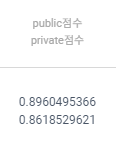

In [272]:
from keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model

input_dim = scaled_train_df.shape[1]
input_layer = Input(shape=(input_dim, ))

# Encoder
encoder = Dense(16)(input_layer)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dropout(0.5)(encoder)  

encoder = Dense(32)(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dropout(0.5)(encoder)

# Decoder
decoder = Dense(16)(encoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
decoder = Dropout(0.5)(decoder)

decoder = Dense(input_dim)(decoder)

# Autoencoder 모델 구성
autoencoder = Model(inputs=input_layer, outputs=decoder)

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 출력
autoencoder.summary()


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 8)]               0         
                                                                 
 dense_91 (Dense)            (None, 16)                144       
                                                                 
 batch_normalization_33 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 16)                0         
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_92 (Dense)            (None, 32)                544       
                                                          

In [273]:
# 학습 데이터와 검증 데이터 모두 정상 거래 데이터만 사용
history = autoencoder.fit(scaled_train_df, scaled_train_df,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(scaled_val_df, val_df['Class']),
                          verbose=1,
                          callbacks=[checkpointer, early_stopping])



Epoch 1/100
3558/3558 [==============================] - 42s 10ms/step - loss: 0.8161 - val_loss: 0.1279
Epoch 2/100
3558/3558 [==============================] - 36s 10ms/step - loss: 0.6789 - val_loss: 0.1465
Epoch 3/100
3558/3558 [==============================] - 35s 10ms/step - loss: 0.6657 - val_loss: 0.1484
Epoch 4/100
3558/3558 [==============================] - 36s 10ms/step - loss: 0.6608 - val_loss: 0.1511
Epoch 5/100
3558/3558 [==============================] - 38s 11ms/step - loss: 0.6587 - val_loss: 0.1585
Epoch 6/100
3558/3558 [==============================] - 37s 10ms/step - loss: 0.6569 - val_loss: 0.1590
Epoch 7/100
3558/3558 [==============================] - 37s 10ms/step - loss: 0.6560 - val_loss: 0.1603
Epoch 8/100
3558/3558 [==============================] - 38s 11ms/step - loss: 0.6545 - val_loss: 0.1567
Epoch 9/100
3558/3558 [==============================] - 38s 11ms/step - loss: 0.6555 - val_loss: 0.1620
Epoch 10/100
3558/3558 [==============================]

In [274]:
# 예측 및 이상치 탐지
predictions = autoencoder.predict(scaled_test_data)
mse = np.mean(np.power(scaled_test_data - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# 정상과 사기 거래 간의 재구성 오류 임계값 설정
threshold = np.mean(error_df['reconstruction_error']) + 1.5 * np.std(error_df['reconstruction_error'])

# 임계값을 기준으로 사기 거래 예측
error_df['prediction'] = (error_df['reconstruction_error'] > threshold).astype(int)

# 결과 출력
print("예측된 사기 거래 수:", error_df['prediction'].sum())


4454/4454 [==============================] - 19s 4ms/step
예측된 사기 거래 수: 399


In [275]:
submit = pd.read_csv(path + 'sample_submission.csv')
submit['Class'] = error_df['prediction']
submit.to_csv('./피쳐선정 후 오토인코더 두개 합친거.csv', index=False)

# 85%
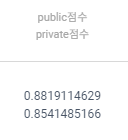

# 코드 공유 

In [1]:
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## 하이퍼파라미터

In [3]:
EPOCHS = 400
LR = 1e-2
BS = 16384
SEED = 41

## 시드고정

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED) # Seed 고정

## 데이터로드

In [5]:
train_df = pd.read_csv('./train.csv')
train_df = train_df.drop(columns=['ID'])
val_df = pd.read_csv('./val.csv')
val_df = val_df.drop(columns=['ID'])

## 데이터셋 생성

In [6]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
        
    def __getitem__(self, index):
        if self.eval_mode:
            self.x = self.df[index]
            self.y = self.labels[index]
            return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    def __len__(self):
        return len(self.df)

In [7]:
train_dataset = MyDataset(df=train_df, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=6)

val_dataset = MyDataset(df = val_df, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=6)

## 1D AutoEncoder

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(30,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,30),
        )
        
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

## Train (학습)

In [9]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.L1Loss().to(self.device)
        
    def fit(self, ):
        self.model.to(self.device)
        best_score = 0
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()

                _x = self.model(x)
                loss = self.criterion(x, _x)

                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            score = self.validation(self.model, 0.95)
            print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}] Val Score : [{score}])')

            if self.scheduler is not None:
                self.scheduler.step(score)

            if best_score < score:
                best_score = score
                torch.save(model.module.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
    
    def validation(self, eval_model, thr):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        eval_model.eval()
        pred = []
        true = []
        with torch.no_grad():
            for x, y in iter(self.val_loader):
                x = x.float().to(self.device)

                _x = self.model(x)
                diff = cos(x, _x).cpu().tolist()
                batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
                pred += batch_pred
                true += y.tolist()

        return f1_score(true, pred, average='macro')

## 모델 학습

In [10]:
model = nn.DataParallel(AutoEncoder())
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5368079159940992] Val Score : [0.0028453569581759065])
Epoch : [1] Train loss : [0.3531084784439632] Val Score : [0.11501328578873722])
Epoch : [2] Train loss : [0.2670650950499943] Val Score : [0.30215156887714245])
Epoch : [3] Train loss : [0.2175464928150177] Val Score : [0.3790190027871001])
Epoch : [4] Train loss : [0.18641855461256845] Val Score : [0.44666852712828586])
Epoch : [5] Train loss : [0.16549089550971985] Val Score : [0.4737767031394002])
Epoch : [6] Train loss : [0.15075396852833883] Val Score : [0.48597195851029973])
Epoch : [7] Train loss : [0.14078528540475027] Val Score : [0.49245822793194194])
Epoch : [8] Train loss : [0.1326482892036438] Val Score : [0.49735580431507725])
Epoch : [9] Train loss : [0.1282434623156275] Val Score : [0.5004386933604956])
Epoch : [10] Train loss : [0.12294097138302666] Val Score : [0.5021549338455491])
Epoch : [11] Train loss : [0.11813775237117495] Val Score : [0.5036468616836273])
Epoch : [12] Train loss

## 추론

In [11]:
model = AutoEncoder()
model.load_state_dict(torch.load('./best_model.pth'))
model = nn.DataParallel(model)
model.eval()

DataParallel(
  (module): AutoEncoder(
    (Encoder): Sequential(
      (0): Linear(in_features=30, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=64, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (Decoder): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=64, out_features=30, bias=True)
    )
  )
)

In [12]:
test_df = pd.read_csv('./test.csv')
test_df = test_df.drop(columns=['ID'])

In [13]:
test_dataset = MyDataset(test_df, False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=6)

In [16]:
def prediction(model, thr, test_loader, device):
    model.to(device)
    model.eval()
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    pred = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            
            _x = model(x)
            
            diff = cos(x, _x).cpu().tolist()
            batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
            pred += batch_pred
    return pred

In [17]:
preds = prediction(model, 0.95, test_loader, device)

# 90%

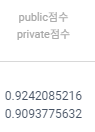

# <center> 최종 결과 </center>

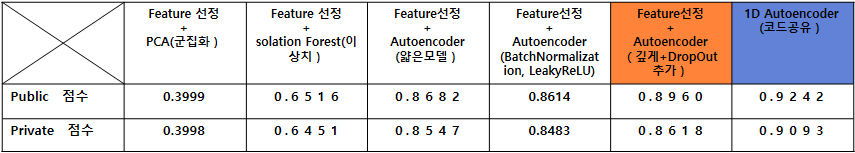

# PacMap 

- Local Structure : 고차원 공간에서 각 데이터들의 가까운 이웃과의 관계를 의미(가까운 데이터 포인트들 간의 상대적 위치나 유사도) (작은의미)
- Global Structure : 전체 데이터셋의 분포나 큰 규모의 클러스터링 패턴을 의미(큰 의미)
- Perplexity Parameter : Perplexity 값이 낮으면 로컬 구조에 더 중점을 두고, 높으면 더 많은 글로벌 구조를 고려(매개변수)

#### PaCMAP의 주목표는 local/global str. 를 유지하는데 차원 축소 방법론의 어떤 부분이 중요하게 작용하는지 이해
#### local str. 유지를 위한 loss fuction에 여러 유용한 design principles을 제안
- Loss function은 3개의 부분으로 나눌 수 있는데
    - Near pairs를 서로 가깝게하는 부분
    - Mid-near pairs를 약하게 가깝게 하는 부분
    -  Further pairs를 멀게 하는 부분
- Loss를 최소화하기 위해서 3가지 stage로 나눠 학습을 진행
#### 각 stage별로 가중치를 달리해서 loss의 각 부분의 영향도가 매 stage마다 달라지고 그것들이 모여 local/global을 잘 구분하게 됩니다.

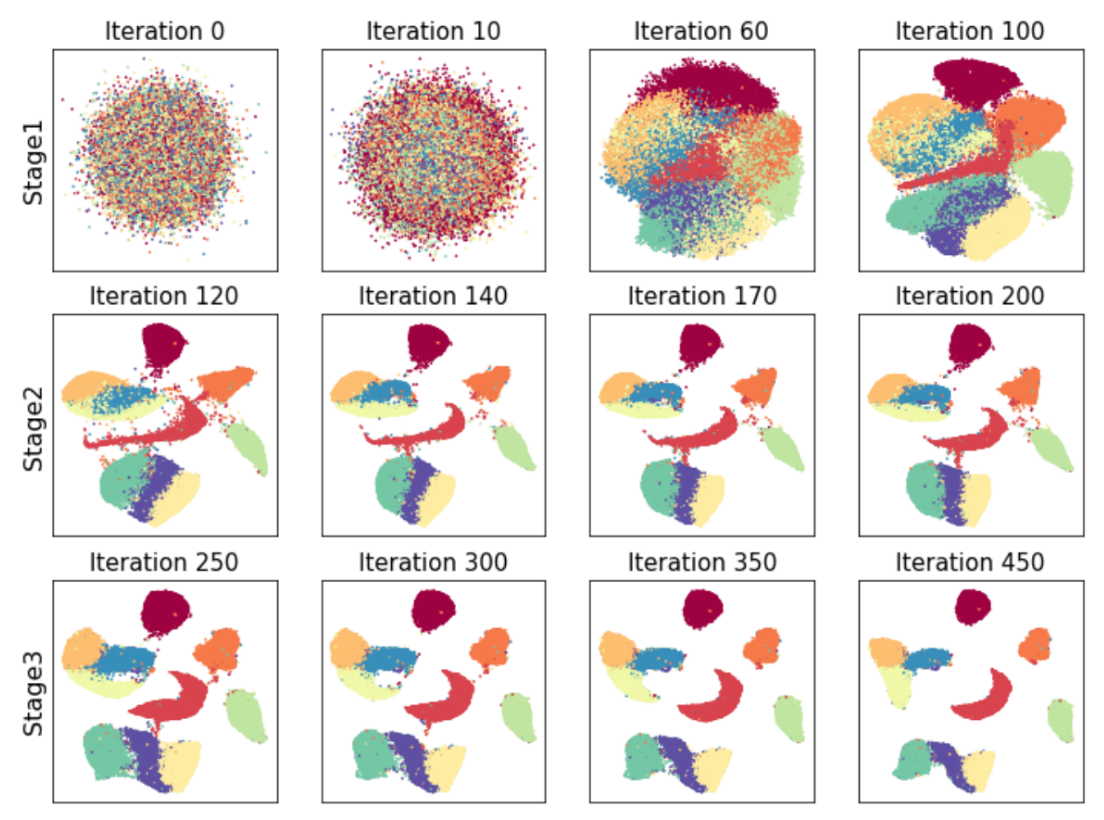